### Loading up required libraries and configurations

In [1]:
import quandl
import pandas_datareader.data as web
import datetime
import pandas as pd
import sklearn
import numpy as np
from collections import defaultdict
from IPython.display import display
import scipy as sp
from operator import methodcaller
import time

#set reload
%reload_ext autoreload
%autoreload 1

# evaluate usage
pd.options.mode.chained_assignment = None  # default='warn'

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
quandl.ApiConfig.api_key = # insert your key here

In [3]:
ibx50 = ['ABEV3','BBAS3','BBDC3','BBDC4','BBSE3','BRFS3','BRKM5','BRML3','BVMF3',
         'CCRO3','CIEL3','CMIG4','CPFE3','CSAN3','CSNA3','CTIP3','EGIE3','EMBR3',
         'ENBR3','EQTL3','ESTC3','FIBR3','GGBR4','GOAU4','HYPE3','ITSA4','ITUB4',
         'JBSS3','KLBN1','KROT3','LAME4','LREN3','MRVE3','MULT3','NATU3','PCAR4',
         'PETR3','PETR4','QUAL3','RADL3','RUMO3','SBSP3','SMLE3','SUZB5','UGPA3',
         'USIM5','VALE3','VALE5','VIVT4','WEGE3']

### Optimizing parameters with ~~genetic algorithm~~ grid search

Given a simple trading strategy: buy stock X, hold for N days, sell it once it reaches V% valuation.
We will the optimal parameters for N (span, or number of days you hold the asset in the portfolio) and V (expected valuation before sell). For simplification, the stop loss will be optimized by the trading agent, and not used in the classification problem.

In [ ]:
# prep data
%aimport data_transform
%aimport simulator
start_date='2002-1-1'
end_date='2014-12-31'
market_df = data_transform.download_market_data(start_date=start_date, end_date=end_date)

In [48]:
# do this in a grid search, simple way first, then switch to GA. 
# don't have head to do GA now

# define a group of stocks in which the algorithm will be tested
stocks= ['ABEV3', 'BBDC4', 'ITUB4', 'PETR4', 'VALE5'] # represents around 25% of IBOV

# create dictionary with results
results = []
avg = lambda x:sum(x)/len(x)
for span in np.arange(1,20,1):
    for profit in np.arange(.01,0.1,.005):
        means = []
        deviations = []
        ratios = []
        for symbol in stocks:
            score_mean, score_std, y_ratio  = data_transform.score_classifier(symbol, market_df, 
                                                               start_date, end_date, span=span, profit=profit)
            # print("symbol {}: {:.2f}, {:.2f}, {:.2f}".format(symbol, score_mean, score_std, y_ratio))
            means.append(score_mean)
            deviations.append(score_std)
            ratios.append(y_ratio)
        result = (span, profit, avg(means), avg(deviations), avg(ratios))
        print("span {}, profit {:.3f}: mean {:.2f}, std {:.2f}, y_ratio {:.2f}".format(*result))
        results.append(result)
        

span 1, profit 0.010: mean 0.32, std 0.07, y_ratio 0.28
span 1, profit 0.015: mean 0.25, std 0.08, y_ratio 0.20
span 1, profit 0.020: mean 0.25, std 0.14, y_ratio 0.15
span 1, profit 0.025: mean 0.23, std 0.16, y_ratio 0.10
span 1, profit 0.030: mean 0.22, std 0.21, y_ratio 0.07
span 1, profit 0.035: mean 0.18, std 0.24, y_ratio 0.05
span 1, profit 0.040: mean 0.07, std 0.16, y_ratio 0.04
span 1, profit 0.045: mean 0.04, std 0.07, y_ratio 0.03
span 1, profit 0.050: mean 0.05, std 0.07, y_ratio 0.02
span 1, profit 0.055: mean 0.01, std 0.03, y_ratio 0.02
span 1, profit 0.060: mean 0.01, std 0.02, y_ratio 0.01
span 1, profit 0.065: mean 0.06, std 0.09, y_ratio 0.01
span 1, profit 0.070: mean 0.00, std 0.00, y_ratio 0.01
span 1, profit 0.075: mean 0.02, std 0.03, y_ratio 0.01
span 1, profit 0.080: mean 0.00, std 0.00, y_ratio 0.01
span 1, profit 0.085: mean 0.00, std 0.00, y_ratio 0.01
span 1, profit 0.090: mean 0.00, std 0.00, y_ratio 0.00
span 1, profit 0.095: mean 0.00, std 0.00, y_rat

In [427]:
df = pd.DataFrame(results, columns=['Span', 'Profit', 'Precision_mean', 'Precision_std', 'Y_ratio'])

In [428]:
df['Precision_95'] = df['Precision_mean'] - 2*df['Precision_std']

In [429]:
df['Profit_per_day'] = df['Profit'] / df['Span']

In [430]:
df.describe()

,Span,Profit,Precision_mean,Precision_std,Y_ratio,Precision_95,Profit_per_day
count,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000
mean,10.000000,0.052500,0.726666,0.058111,0.312873,0.610444,0.009803
std,5.485251,0.025979,0.196100,0.066134,0.198456,0.287886,0.013860
min,1.000000,0.010000,0.000000,0.000000,0.003689,-0.389487,0.000526
25%,5.000000,0.030000,0.705550,0.024533,0.155508,0.574180,0.003000
50%,10.000000,0.052500,0.807747,0.034165,0.282840,0.733078,0.005139
75%,15.000000,0.075000,0.845991,0.057351,0.455893,0.789251,0.010000
max,19.000000,0.095000,0.877437,0.386246,0.763573,0.849706,0.095000


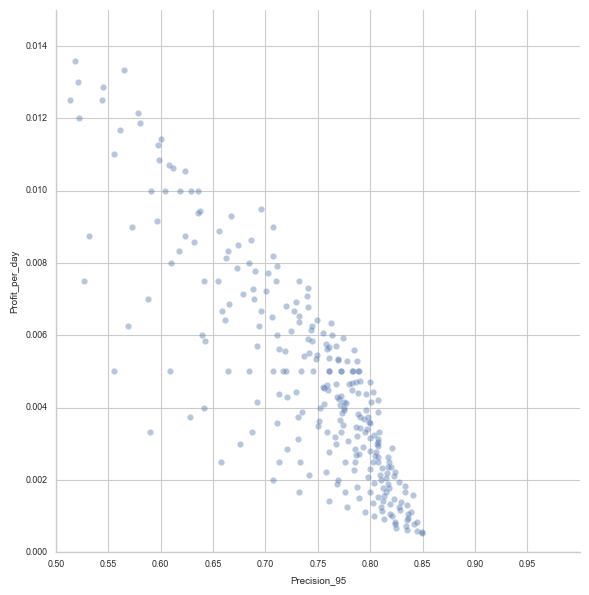

In [447]:
# plt.rcParams['figure.figsize']=(10,80)
sns.lmplot('Precision_95', 'Profit_per_day', data=df, fit_reg=False, scatter_kws={'alpha':0.4}, size=6)
sns.plt.xticks(np.arange(.5,1,.05))
sns.plt.yticks(np.arange(0,.11,.002))
sns.plt.xlim(.5,);
sns.plt.ylim(0,.015);

Precision decreases when profit per day increases. Yes, there are variations, but it might more due to randomness (noise) than to a pattern. Let's look at how precision is related to the y_ratio, meaning the number of times the strategy worked divided by the total number of days, If y_ratio is 50%, it means every other day the strategy would have triggered a positive return.

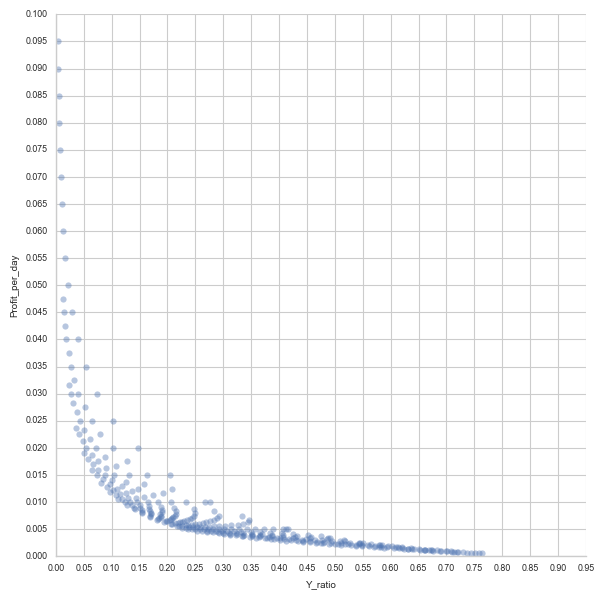

In [446]:
# plt.rcParams['figure.figsize']=(10,80)
sns.set_context("paper", font_scale=0.8)  
sns.lmplot('Y_ratio', 'Profit_per_day', data=df, fit_reg=False, scatter_kws={'alpha':0.4}, size=6)
sns.plt.xticks(np.arange(0,1,.05))
sns.plt.yticks(np.arange(0,.11,.005));
sns.plt.xlim(0,);
sns.plt.ylim(0,.1);

That is an interesting curve, although not so surprising, since the profit per day is also a log curve. Let's see how y_ratio affects precision

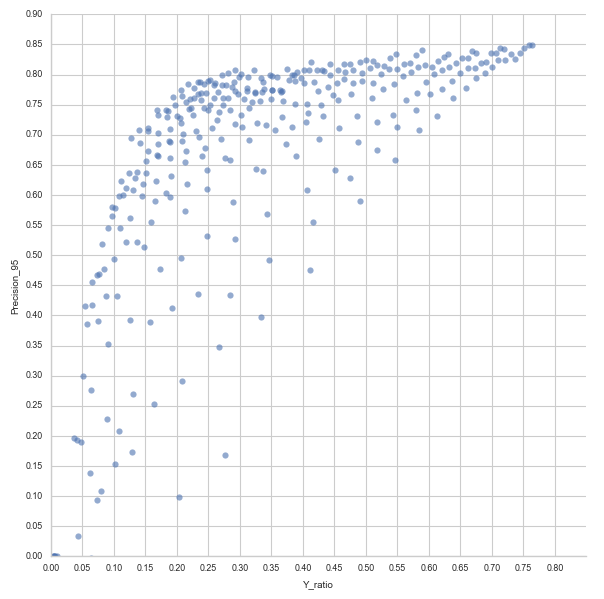

In [448]:
# plt.rcParams['figure.figsize']=(10,80)
sns.lmplot('Y_ratio', 'Precision_95', data=df, fit_reg=False, scatter_kws={'alpha':0.6}, size=6)
sns.plt.xticks(np.arange(0,1,.05))
sns.plt.yticks(np.arange(0,1,.05))
sns.plt.xlim(0,.85);
sns.plt.ylim(0,.9);

Precision increases when y_ration increses, but the sudden increase is more or less at the .2 point. 

So if I pick a point with y_ratio about .3 (3 in 10), I can get aim for a Precision_95 of 80%, which is pretty high, and a profit per day of around 1%.

A profit per day of 1%, given 80% precision, should have a net return of 0.8%. That multiplied by 20 gives around a 16% return per month - pretty high, if it can be used to trade consistently.

Let's first select the optimal point and then backtest this strategy.

In [434]:
# how to select the optimal strategy?
# is the one with the highest precision_95 * profit_per_day

df['Net_profit'] = df['Precision_95'] * df['Profit_per_day']

In [435]:
df.describe()

,Span,Profit,Precision_mean,Precision_std,Y_ratio,Precision_95,Profit_per_day,Net_profit
count,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000
mean,10.000000,0.052500,0.726666,0.058111,0.312873,0.610444,0.009803,0.002708
std,5.485251,0.025979,0.196100,0.066134,0.198456,0.287886,0.013860,0.003433
min,1.000000,0.010000,0.000000,0.000000,0.003689,-0.389487,0.000526,-0.016553
25%,5.000000,0.030000,0.705550,0.024533,0.155508,0.574180,0.003000,0.001649
50%,10.000000,0.052500,0.807747,0.034165,0.282840,0.733078,0.005139,0.003125
75%,15.000000,0.075000,0.845991,0.057351,0.455893,0.789251,0.010000,0.004593
max,19.000000,0.095000,0.877437,0.386246,0.763573,0.849706,0.095000,0.008313


I've calculated the mas next profit as 0.8%, and the table shows 0.83%, very close. What is this data point?

In [436]:
df.iloc[df['Net_profit'].idxmax()]

Span              4.000000
Profit            0.080000
Precision_mean    0.648144
Precision_std     0.116240
Y_ratio           0.054383
Precision_95      0.415664
Profit_per_day    0.020000
Net_profit        0.008313
Name: 68, dtype: float64

In [437]:
# That is not what I'm looking for. Because I need to consider losing money as well as getting 
# What if I calculate loss?
# It will be 1-precision * profit
# That should adjust my model
df['Net_loss'] = (df['Precision_95']-1)*df['Profit_per_day']
df['Net_result'] = df['Net_profit'] + df['Net_loss']

In [438]:
df.describe()

,Span,Profit,Precision_mean,Precision_std,Y_ratio,Precision_95,Profit_per_day,Net_profit,Net_loss,Net_result
count,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000
mean,10.000000,0.052500,0.726666,0.058111,0.312873,0.610444,0.009803,0.002708,-0.007095,-0.004387
std,5.485251,0.025979,0.196100,0.066134,0.198456,0.287886,0.013860,0.003433,0.015702,0.018016
min,1.000000,0.010000,0.000000,0.000000,0.003689,-0.389487,0.000526,-0.016553,-0.095000,-0.095000
25%,5.000000,0.030000,0.705550,0.024533,0.155508,0.574180,0.003000,0.001649,-0.004116,0.000553
50%,10.000000,0.052500,0.807747,0.034165,0.282840,0.733078,0.005139,0.003125,-0.001362,0.001602
75%,15.000000,0.075000,0.845991,0.057351,0.455893,0.789251,0.010000,0.004593,-0.000645,0.002388
max,19.000000,0.095000,0.877437,0.386246,0.763573,0.849706,0.095000,0.008313,-0.000079,0.003732


In [439]:
# second try - maximize net result
df.iloc[df['Net_result'].argmax()]

Span              10.000000
Profit             0.090000
Precision_mean     0.808170
Precision_std      0.050420
Y_ratio            0.139487
Precision_95       0.707331
Profit_per_day     0.009000
Net_profit         0.006366
Net_loss          -0.002634
Net_result         0.003732
Name: 178, dtype: float64

In [ ]:
# that is more like I was expecting. An algorithm with a 70% precision, given a 95% confidence interval.
# Span of 10 days
# Expected profit of 9% 
# What if I use this parameters to play the market? How far can I get?

In [ ]:
# generate a table to include in the article showing how precision increases 


### Full backtesting with multiple stocks in multiple periods

We will extend the model to simulate an actual scenario, where the operator have multiple stocks available. We will start by defining a set of stocks to operate. To make the comparison easier, we will only operate with the stocks belonging to the index IBV50, which contains the 50 most relevant stocks in Brazilian Market by traded volume.

In [4]:
%aimport data_transform
%aimport simulator

In [5]:
start_date='2002-1-1'
end_date='2016-12-31'
market_df = data_transform.download_market_data(start_date=start_date, end_date=end_date)

In [125]:
# create analysts
stocks= ['ABEV3', 'BBDC4', 'ITUB4', 'PETR4', 'VALE5'] # represents around 25% of IBOV
# top10_stocks= ['ABEV3','ITUB4','BBDC4' ,'BBAS3','ITSA4','PETR4','VALE5', 'CIEL3', 'BBSE3', 'BRFS3']
analysts = []
span = 10
profit = .09
end_date_train =  '2014-12-31'
start_date_test = '2015-01-01'
for symbol in stocks:
    clf, scaler, pca, score = data_transform.gen_classifier(symbol, market_df, 
                                                       start_date, end_date_train, span=span, profit=profit)
    # need to fix this back_test data... why 2014-06-30? 
    data = data_transform.prep_backtest_data(symbol, market_df, 
                                             '2014-6-30', end_date, base=60)
    analysts.append(simulator.Analyst(symbol, data, clf, scaler, pca, score))


[3105  228]
Precision for ABEV3: 0.87 (+/- 0.14)
[1425  233]
Precision for BBDC4: 0.73 (+/- 0.21)
[2757  426]
Precision for ITUB4: 0.74 (+/- 0.16)
[2661  503]
Precision for PETR4: 0.86 (+/- 0.09)
[2498  460]
Precision for VALE5: 0.80 (+/- 0.11)


In [127]:
# create operator
bt_start_date = start_date_test
bt_end_date = end_date
trading_days = list(data_transform.get_stock_data('PETR4', bt_start_date, bt_end_date).index)

In [128]:
span = span 
profit = profit
loss = -profit
scores = []
for idx in range(5):
    op = simulator.Operator((span, profit, loss), analysts, capital=100000, 
                            start_date=bt_start_date, end_date=bt_end_date, op_days=trading_days)
    op.run()
    scores.append(op.capital / 100000.0 - 1)
print("Span: {}, Profit: {:.2f}, Loss: {:.2f}, Return: {:.2f}".format(
        span,profit,loss, sum(scores)/len(scores)))

Span: 10, Profit: 0.09, Loss: -0.09, Return: 2.57


In [129]:
print(op.capital)
for operation in op.operations:
    operation.report()

356973.692194
Symbol: PETR4, Start: 2015-01-02 00:00:00, End: 2015-01-06 00:00:00, Gain_loss: -11.00%, R$ -11004.27, Days Left: 8
Symbol: VALE5, Start: 2015-01-02 00:00:00, End: 2015-01-16 00:00:00, Gain_loss: 2.67%, R$ 0.00, Days Left: 0
Symbol: PETR4, Start: 2015-01-06 00:00:00, End: 2015-01-08 00:00:00, Gain_loss: 10.20%, R$ 9081.20, Days Left: 8
Symbol: PETR4, Start: 2015-01-08 00:00:00, End: 2015-01-22 00:00:00, Gain_loss: 11.66%, R$ 11431.62, Days Left: 0
Symbol: PETR4, Start: 2015-01-16 00:00:00, End: 2015-01-30 00:00:00, Gain_loss: -13.35%, R$ -0.00, Days Left: 0
Symbol: PETR4, Start: 2015-02-10 00:00:00, End: 2015-02-13 00:00:00, Gain_loss: 12.00%, R$ 13136.11, Days Left: 7
Symbol: BBDC4, Start: 2015-02-13 00:00:00, End: 2015-03-03 00:00:00, Gain_loss: 1.58%, R$ 1934.37, Days Left: 0
Symbol: BBDC4, Start: 2015-03-03 00:00:00, End: 2015-03-10 00:00:00, Gain_loss: -9.31%, R$ -11602.87, Days Left: 5
Symbol: PETR4, Start: 2015-03-10 00:00:00, End: 2015-03-20 00:00:00, Gain_loss: 9

In [130]:
import pandas_datareader.data as web
df = web.DataReader('^BVSP', 'yahoo', bt_start_date, bt_end_date)
df.ix[-1, 'Adj Close']/df.ix[0, 'Adj Close'] - 1

0.32148746701846975

In [342]:
%aimport simulator
def extract_attrs(op):
    return {
        'symbol': op.symbol,
        'price': op.price,
        'qty': op.qty,
        'start_date': op.start_date,
        'end_date': op.end_date,
        'span': op.days_left,
        'gain_loss': op.gain_loss
    }
    

operations = list(map(lambda x:extract_attrs(x), op.operations))

In [343]:
df_op = pd.DataFrame(operations)

In [344]:
df_op = df_op.set_index(['start_date'])

In [345]:
df_op.head()

,end_date,gain_loss,price,qty,span,symbol
start_date,,,,,,
2015-01-02,2015-01-06,-0.110043,9.36000,1.068376e+04,8,PETR4
2015-01-02,2015-01-16,0.026695,17.58391,8.275699e-13,0,VALE5
2015-01-06,2015-01-08,0.102041,8.33000,1.068376e+04,8,PETR4
2015-01-08,2015-01-22,0.116558,9.18000,1.068376e+04,0,PETR4
2015-01-16,2015-01-30,-0.133475,9.44000,1.582668e-12,0,PETR4


In [346]:
df_op['amount'] = df_op['price'] * df_op['qty']

In [347]:
df_op['return'] = df_op['amount'] / 100000

In [348]:
df_op = df_op[df_op['amount']>1]

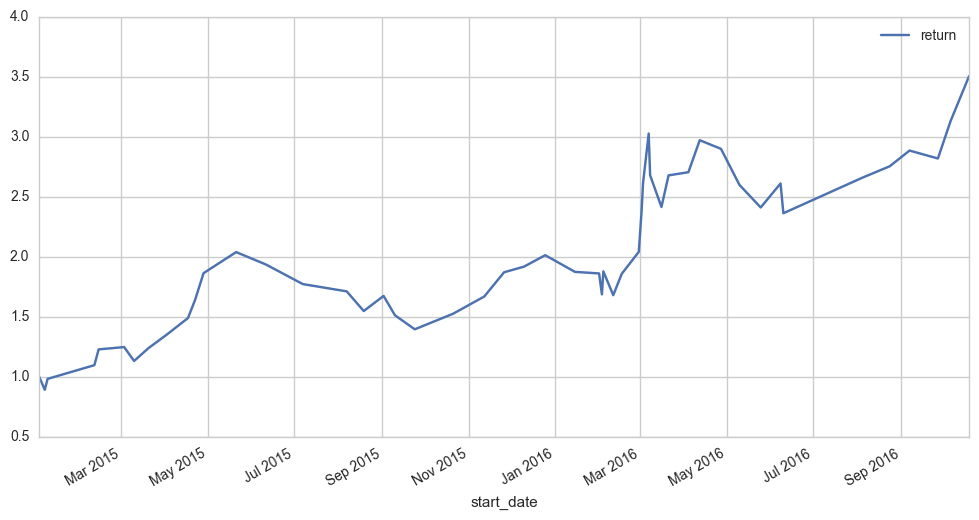

In [349]:
# plot for results
plt.rcParams['figure.figsize']=(12,6)
df_op[df_op['return']>0.1].plot(y='return')

In [418]:
# plot for IBOV
stocks= ['ABEV3.SA', 'BBDC4.SA', 'ITUB4.SA', 'PETR4.SA', 'VALE5.SA', '^BVSP' ]
df_plot = df_op['return']
df_plot.index.rename('date', inplace=True)
for symbol in stocks:
    df_stock = web.DataReader(symbol, 'yahoo', bt_start_date, bt_end_date)
    df_stock[symbol] = df_stock['Adj Close'] / df_stock.ix['2015-01-02', 'Adj Close']
    df_stock = df_stock.reindex(index=df_plot.index)
    df_plot = pd.concat([df_stock[symbol], df_plot], axis=1).dropna()

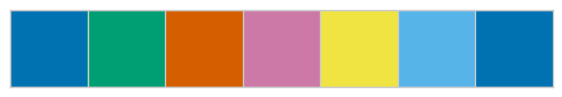

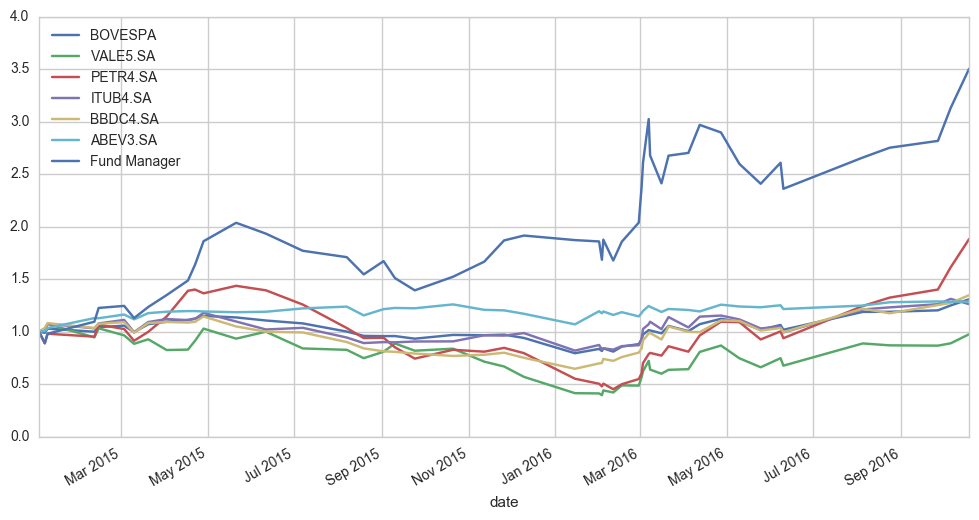

In [426]:

# colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", 'pink']
sns.palplot(sns.color_palette("colorblind", 7))
# sns.palplot(sns.xkcd_palette(colors))
df_plot = df_plot.rename(columns={'Bovespa': 'BOVESPA', 'return': 'Fund Manager'})
sns.set(style='whitegrid')
plt.rcParams['figure.figsize']=(12,6)
df_plot.plot()


In [416]:
# compare variances
# plot for IBOV
stocks= ['^BVSP' ]
df_op['daily_return'] = df_op['amount'] / df_op['amount'].shift(1)
df_plot = df_op['daily_return']
df_plot.index.rename('date', inplace=True)
for symbol in stocks:
    df_stock = web.DataReader(symbol, 'yahoo', bt_start_date, bt_end_date)
    df_stock[symbol] = df_stock['Adj Close'] / df_stock['Adj Close'].shift(1)
    df_stock = df_stock.reindex(index=df_plot.index)
    df_plot = pd.concat([df_stock[symbol], df_plot], axis=1)
df_plot = df_plot.dropna();

(0.87503937007874022, 1.177056074766355)

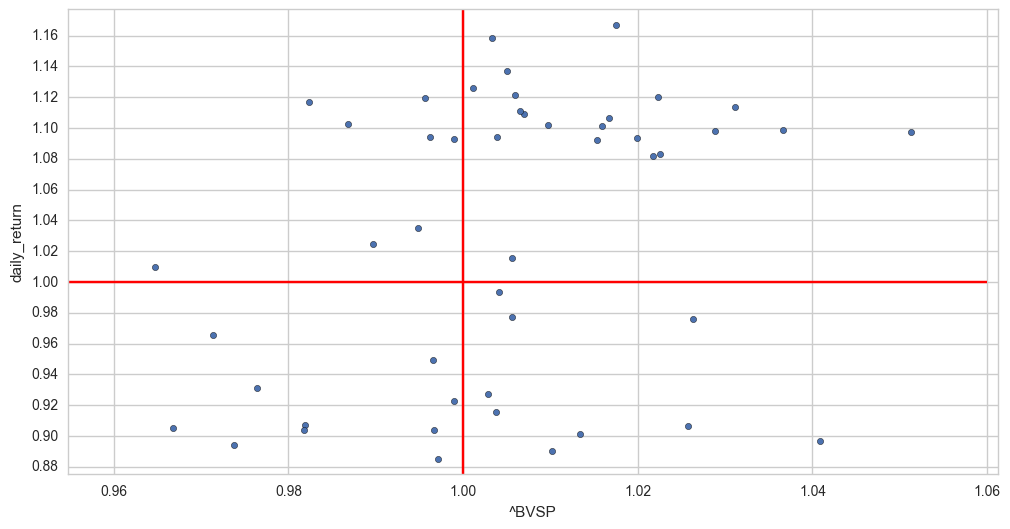

In [400]:
df_plot.plot(kind='scatter', x='^BVSP', y='daily_return')
plt.vlines(1, 0.8, 1.2, color='red')
plt.hlines(1, .94, 1.06, color='red')
plt.yticks(np.arange(.8,1.2,.02));
plt.xticks(np.arange(.94,1.06,.02));
plt.xlim(df_plot['^BVSP'].min()-.01,df_plot['^BVSP'].max()+.01)
plt.ylim(df_plot['daily_return'].min()-.01,df_plot['daily_return'].max()+.01)
# draw vertical line from (70,100) to (70, 250)
# plt.plot([0, 1], [2, 1], 'k-', lw=2)

# draw diagonal line from (70, 90) to (90, 200)
# plt.plot([70, 90], [90, 200], 'k-')

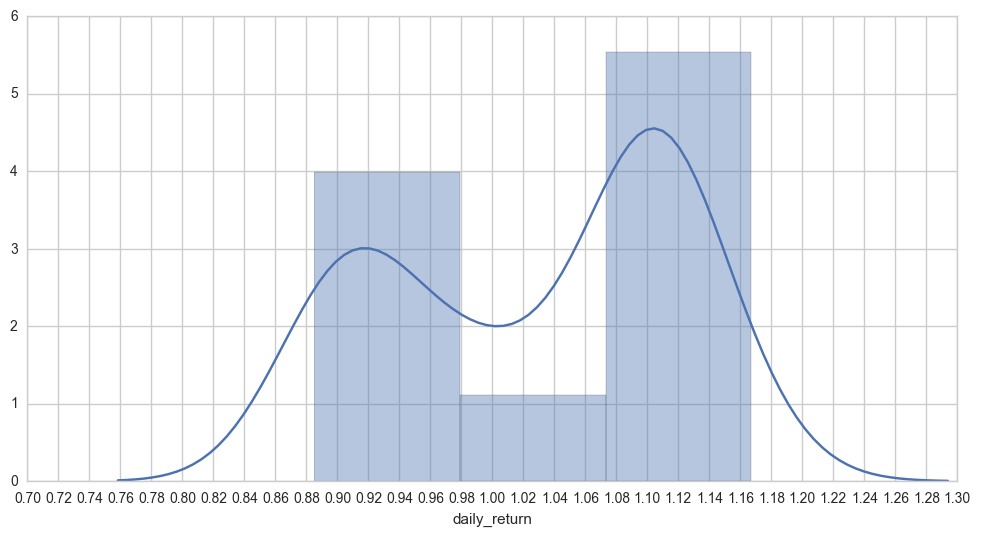

In [415]:
import imp
plt = imp.reload(plt)
sns.distplot(df_plot['daily_return'])
plt2.xticks(np.arange(.7,1.3,0.02));

In [ ]:
# easy - this is not daily_return, but rather a distribution of the returns
# since the strategy is to sell when it reaches 9% valuation or devaluation, it makes sense